In [1]:
import os
import pickle
import joblib
import torch
import yaml
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from tiatoolbox.models.engine.nucleus_instance_segmentor import NucleusInstanceSegmentor
from utils.utils_inflams import (
    color_dict_pannuke,
    get_Inflammatory,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("running on", device)

|2025-12-14|13:12:33.012| [WARNING] /usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

|2025-12-14|13:12:36.783| [WARNING] /usr/local/lib/python3.12/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()



running on cuda


In [2]:
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)
vis_scale = config["patching"]["vis_scale"]
pth_to_inflams_dats = "../" + config["paths"]["pth_to_inflams_dats"]
patches_dir = "../" + config["paths"]["pth_to_patches"].replace(
    "patches", "patches_bis"
)
coords_pickles = "../" + config["paths"]["pth_to_coords"]
inflams_pickles = "../" + config["paths"]["pth_to_inflams_ckpts"]
inflams_wsis_results = "../" + config["paths"]["pth_to_inflams_wsis"]

In [ ]:
slide_name = "120C"
with open(f"{coords_pickles}/{slide_name}_coords_checkpoint.pickle", "rb") as handle:
    coords = pickle.load(handle)

coords_x, coords_y = [], []
for patch in os.listdir(f"{patches_dir}/{slide_name}"):
    _, _, x, _, y = patch[:-4].split("_")
    coords_x.append(int(x))
    coords_y.append(int(y))

scaled_slide = coords["scaled_slide"]
[x_start, y_start, x_end, y_end] = coords["xy_start_end"]
[real_x, real_y, real_w, real_h] = coords["xywh_real"]
width, height = int(real_w * vis_scale), int(real_h * vis_scale)
coords_x = np.array(coords_x) * vis_scale - x_start
coords_y = np.array(coords_y) * vis_scale - y_start

In [4]:
model = NucleusInstanceSegmentor(
    pretrained_model="hovernet_fast-pannuke", batch_size=128
)

save_dir = f"{pth_to_inflams_dats}/{slide_name}/"
images = [
    os.path.join(f"{patches_dir}/{slide_name}", e)
    for e in os.listdir(f"{patches_dir}/{slide_name}")
]
tile_output = model.predict(
    images,
    mode="tile",
    save_dir=save_dir,
    device=device,
    crash_on_exception=True,
)

|2025-12-14|13:12:37.759| [WARNING] torch-compile is currently not supported in Python 3.12+.
  0%|          | 0/4993 [00:00<?, ?it/s]|2025-12-14|13:12:38.814| [WARNING] /usr/local/lib/python3.12/dist-packages/tiatoolbox/models/architecture/hovernet.py:601: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  marker = remove_small_objects(marker, min_size=obj_size)

  0%|          | 14/4993 [00:04<24:22,  3.41it/s]|2025-12-14|13:12:42.746| [WARNING] /usr/local/lib/python3.12/dist-packages/tiatoolbox/models/architecture/hovernet.py:537: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  blb = remove_small_objects(blb, min_size=10)

100%|██████████| 4993/4993 [25:53<00:00,  3.21it/s]


In [5]:
file_map = joblib.load(f"{save_dir}/file_map.dat")
dict4 = {}  # dictionary of results: {id: centroid, contour, proba, type}
dict_xy_nucs = {}  # dictionary {x,y): [nuc_id1, nuc_id2,...]}
for im_dir, out_dir in tqdm(
    file_map, desc=f"Processing {save_dir}/file_map.dat", leave=False
):
    out_dir = f"{save_dir}/{out_dir.split('/')[-1]}.dat"
    tile_preds = joblib.load(f"{out_dir}")
    InfLymph_nucleus1, _ = get_Inflammatory(tile_preds, color_dict_pannuke)
    dict4 |= InfLymph_nucleus1
    _, x, _, y = im_dir[:-4].split("_")[-4:]
    dict_xy_nucs[(x, y)] = list(tile_preds.keys())
final_dict = defaultdict(list)
for xy, v in dict_xy_nucs.items():
    final_dict[xy].extend([nuc_id for nuc_id in v if nuc_id in dict4])

coords_x, coords_y, num_nucleus = zip(
    *((int(k[0]), int(k[1]), len(v)) for k, v in final_dict.items())
)
inf_nucleus_sorted, coords_X, coords_Y = zip(
    *sorted(zip(num_nucleus, coords_x, coords_y), key=lambda x: x[0])
)

In [6]:
to_save = {
    "scaled_slide": scaled_slide,
    "coords_x": coords_X,
    "coords_y": coords_Y,
    "inflams": inf_nucleus_sorted,
    "vis_scale": vis_scale,
    "xy_start_end": coords["xy_start_end"],
    "xywh_real": coords["xywh_real"],
}
with open(
    f"{inflams_pickles}/{slide_name}_coords_inflams_checkpoint.pickle", "wb"
) as handle:
    pickle.dump(to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

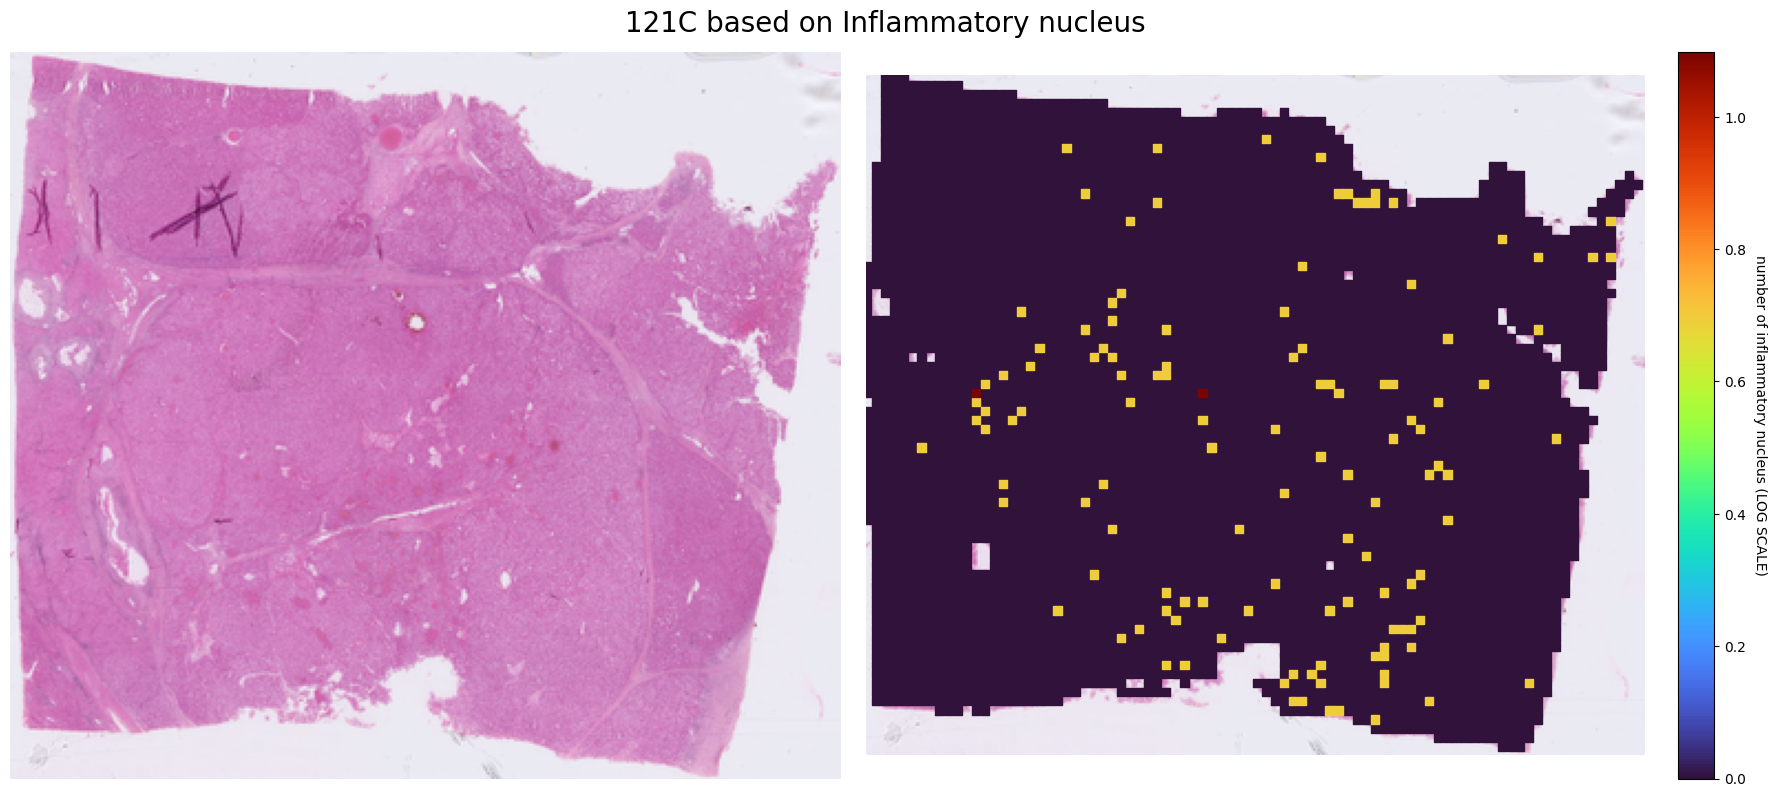

In [7]:
cX = np.array(coords_X) * vis_scale - x_start
cY = np.array(coords_Y) * vis_scale - y_start

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle(f"{slide_name} based on Inflammatory nucleus", fontsize=20)
axes[0].imshow(scaled_slide)
axes[0].axis("off")
axes[1].imshow(scaled_slide)
sc = axes[1].scatter(cX, cY, c=np.log1p(inf_nucleus_sorted), cmap="turbo", marker="s")
axes[1].axis("off")
cbar = fig.colorbar(sc, ax=axes[1], fraction=0.046, pad=0.04)
cbar.set_label("number of inflammatory nucleus (LOG SCALE)", rotation=270, labelpad=15)
plt.tight_layout()
plt.savefig(f"{inflams_wsis_results}/{slide_name}_inflammation_map.png")
plt.show()